## Create Monte Carlo method to integrate posterior

In [38]:
%pylab inline
import mcint
import numpy.random
from Chempy.parameter import ModelParameters
from Chempy.cem_function import posterior_function_for_integration,posterior_function_many_stars
a = ModelParameters()

Populating the interactive namespace from numpy and matplotlib


### TEST with different random generators e.g. gaussian

### Can we speed up posterior_function_for_integration? 
Limiting factor is the 51 iterations of likelihood function... (takes ~3ms each)

In [39]:
# Define function to return posterior predictions (must be exponentiated)
def posterior(theta):
    a = ModelParameters()
    post = posterior_function_for_integration(theta)
    posterior = np.exp(post)
    return posterior

sigma = [] # Read prior sigma from parameter file
for i,param_name in enumerate(a.to_optimize):
    sigma.append(a.priors.get(param_name)[1])
    
def sampler(i):
    while True:
        yield random.uniform(np.array(a.p0)-Nsigma[i]*np.array(sigma),np.array(a.p0)+Nsigma[i]*np.array(sigma),size=6)


In [46]:
Nsamples = [10000,10000,100000] # No MC samples
Nsigma = [1,2,3,3.5] # Width in parameter space
j = 0
integral = []
integral_err = []
for i in range(len(Nsigma)):
    print('Calculating integral %d of %d' %(i,len(Nsigma)))
    domain_size = np.prod(sigma)*(2*Nsigma[i])**len(sigma) # Total domain size
    result,error = mcint.integrate(posterior,sampler(i),n=Nsamples[j],measure=domain_size)
    integral.append(result)
    integral_err.append(error)

Calculating integral 0 of 4
Calculating integral 1 of 4
Calculating integral 2 of 4
Calculating integral 3 of 4


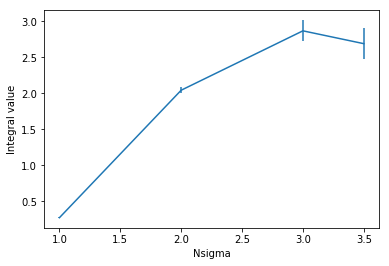

In [47]:
plt.errorbar(Nsigma,integral,yerr=integral_err)
plt.xlabel('Nsigma')
plt.ylabel('Integral value')

In [ ]:
%timeit -r 1 -n 1 result, error = mcint.integrate(posterior, sampler(),n=Nsamples,measure=domain_size)  

In [ ]:
print(result,error)

In [8]:
d1 = []
d2 = []
d3 = []
for i in range(500):
    param = random.uniform(np.array(a.p0)-Nsigma*np.array(sigma),np.array(a.p0)+Nsigma*np.array(sigma),size=6)
    param[2] = a.p0[2]
    param[3] = a.p0[3]
    param[4] = a.p0[4]
    param[5] = a.p0[5]
    post = posterior_function_for_integration(param)
    posterior = np.exp(post)
    d1.append(param[0])
    d2.append(param[1])
    d3.append(posterior)


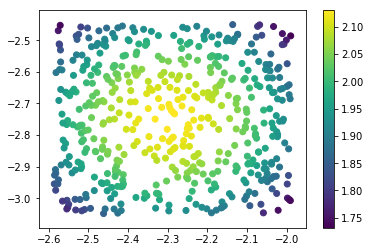

In [9]:
plt.scatter(d1,d2,c=np.log10(d3))
plt.colorbar()

In [10]:
%timeit _ = posterior_function_for_integration([-3.,-3.,-0.8,-0.5,0.6,0.5])

10 loops, best of 3: 26.4 ms per loop


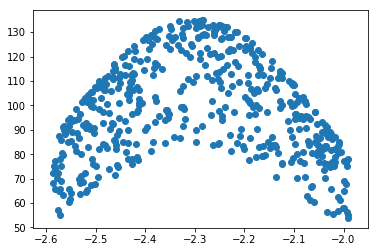

In [11]:
plt.scatter(d1,d3)


In [4]:
%timeit posterior([-3.,-3.,-0.8,-0.5,0.6,0.5])

10 loops, best of 3: 26.3 ms per loop


## New posterior function with error marginalization

In [ ]:
from Chempy.cem_function import posterior_function_many_stars

def posterior(theta):
    a = ModelParameters()
     post,_ = posterior_function_many_stars(np.array(param),np.inf,a.elements_to_trace)
    posterior = np.exp(post)
    return posterior

In [ ]:
a = ModelParameters()
param = [-3,-3,-0.8,-0.3,0.5,0.6]
pos,abun = posterior_function_many_stars(np.array(param),np.inf,a.elements_to_trace)

In [ ]:
pos,abun = posterior_function_many_stars(np.array(param),np.inf,a.elements_to_trace)

In [ ]:
sol_dat = np.load('Chempy/input/stars/Proto-sun.npy')
sol_dat[1]

In [ ]:
b

In [ ]:
proto_sun = np.load('Chempy/input/stars/Proto-sun.npy')
element_list = np.unique(proto_sun.dtype.names,a.elements_to_trace)[0][:-1]
print(element_list)

**Spare code**

def posterior_function_for_integration(changing_parameter,a):
	'''
	This is the posterior function for a single star with beta-error model.
	
	Beta error marginalization MUST be used for this.	
	
	This is for speeding up Bayes' factor integration	
	'''
	from .data_to_test import likelihood_evaluation
	
	# the values in a are updated according to changing_parameters and the prior list is appended
	a = extract_parameters_and_priors(changing_parameter, a)
	
	# the log prior is calculated
	prior = sum(np.log(a.prior))

	# call Chempy and return the abundances at the end of the simulation = time of star's birth and the corresponding element names as a list
	abundance_list,elements_to_trace = cem_real2(a)
		
	abundance_list = abundance_list[:-2]
	elements_to_trace = elements_to_trace[:-2]

	proto_sun = np.load('Chempy/input/stars/Proto-sun.npy')
	element_list = np.unique(proto_sun.dtype.names,elements_to_trace)[0][:-1] # Remove age
	
	## likelihood is calculated (the model error vector is expanded)
	from scipy.stats import beta
	likelihood_list = []
	model_errors = np.linspace(a.flat_model_error_prior[0],a.flat_model_error_prior[1],a.flat_model_error_prior[2])
	error_weight = beta.pdf(model_errors, a = a.beta_error_distribution[1], b = a.beta_error_distribution[2])
	error_weight/= sum(error_weight)
	
	for item in model_errors:
		error_temp = np.ones(len(element_list)) * item 
		likelihood_list.append(likelihood_evaluation(error_temp[:,None], proto_sun[1] , abundance_list, proto_sun[0]))
		likelihood = logsumexp(likelihood_list, b = error_weight)	
	
	likelihood,_,_,_,_ = likelihood_function(a.stellar_identifier, abundance_list, elements_to_trace)

	return(prior+likelihood)